# 机器学习纳米学位
## 项目 7: 猫狗大战 Dog vs. Cat

## 导入需要的库

In [3]:
import numpy as np
import pandas as pd
import os, cv2, zipfile, shutil, h5py

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from tqdm import tqdm
from os.path import isfile, isdir
from sklearn.utils import shuffle

from keras.models import *
from keras.layers import *
from keras.callbacks import *
from keras.applications import *

#from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


## 解压

In [4]:
def unzip_file(f_path):
    fzip = zipfile.ZipFile(f_path)
    fzip.extractall()

train = './train.zip'
train_folder = './train'
test = './test.zip'
test_folder = './test'

if not isdir(train_folder):
    unzip_file(train)
if not isdir(test_folder):
    unzip_file(test)

## 探索数据集
获取每张图片的分辨率以及通道数

In [4]:
train_info = []
for img in tqdm(os.listdir(train_folder)):
    info = cv2.imread(os.path.join(train_folder, img))
    train_info.append((info.shape, img))

100%|██████████| 25000/25000 [01:10<00:00, 352.91it/s]


In [5]:
train_info[0]

((500, 380, 3), 'dog.8011.jpg')

### 图片大小分布

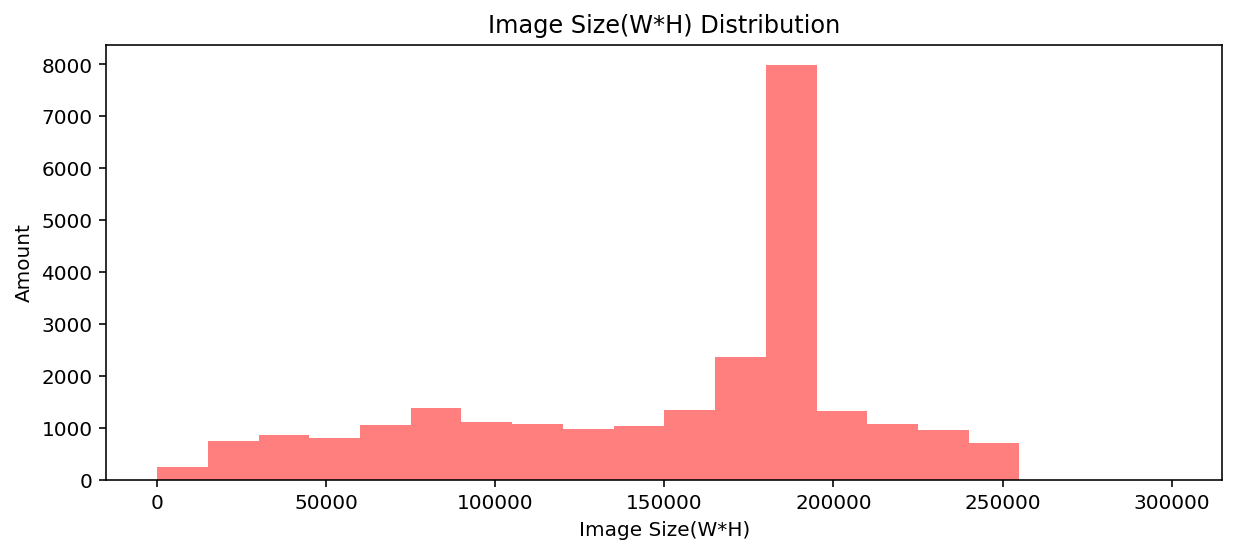

In [6]:
plt.figure(figsize=(10, 4))
img_size = [info[0][0]*info[0][1] for info in train_info]
plt.title("Image Size(W*H) Distribution")
plt.xlabel('Image Size(W*H)')
plt.ylabel('Amount')
plt.hist(img_size, bins = 20, alpha = 0.5, range = (0, 300000), color = 'red', label = 'image_size')
plt.show()

### 显示图片

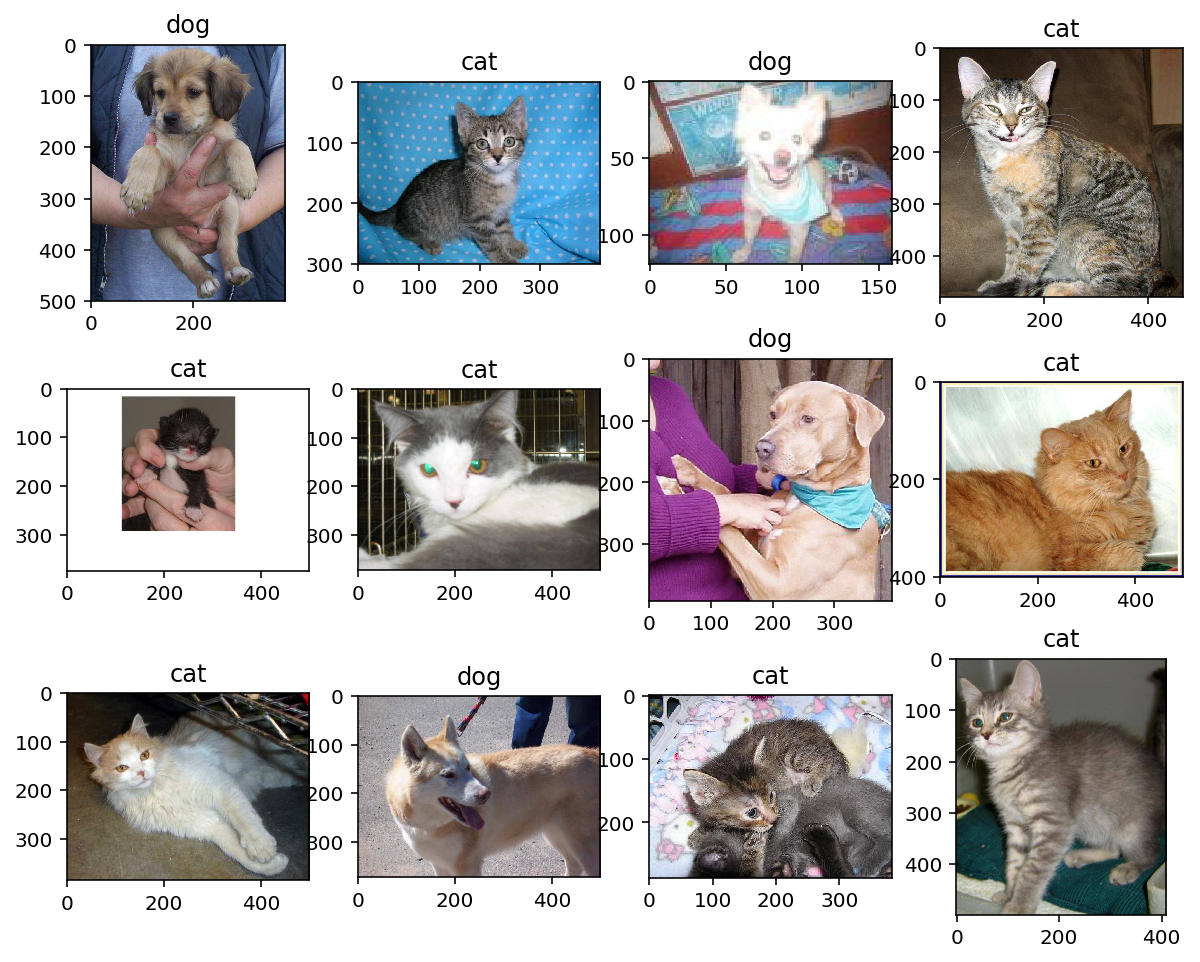

In [7]:
plt.figure(figsize=(10, 8))
for i, file in enumerate(os.listdir(train_folder)[:12]):
    img = plt.imread(os.path.join(train_folder, file))
    plt.subplot(3, 4, i+1)
    plt.title(file.split('.')[0])
    plt.axis('on')
    plt.imshow(img)

plt.show()

## 数据预处理

### 为Keras建立分类目录

In [10]:
TRAIN_GEN = './train_gen'
TRAIN_GEN_DOG = './train_gen/dog'
TRAIN_GEN_CAT = './train_gen/cat'
VAL_GEN = './val_gen'
VAL_GEN_DOG = './val_gen/dog'
VAL_GEN_CAT = './val_gen/cat'

TEST_GEN = './test_gen'
TEST_GEN_MIXED = './test_gen/mixed'

train_cat = [file for file in os.listdir(train_folder) if 'cat' in file][:1000]
train_dog = [file for file in os.listdir(train_folder) if 'dog' in file][:1000]

val_num = int(len(train_dog) * .2)
val_dog = train_dog[-val_num:]
train_dog = train_dog[:-val_num]

val_cat = train_cat[-val_num:]
train_cat = train_cat[:-val_num]

len(train_dog)
len(val_dog)

200

In [11]:
if not isdir(TRAIN_GEN):
    os.mkdir(TRAIN_GEN)
    os.mkdir(TRAIN_GEN_DOG)
    os.mkdir(TRAIN_GEN_CAT)
    for file in train_dog:
        os.symlink('../../train/'+file, TRAIN_GEN_DOG+r'/'+file)
    for file in train_cat:
        os.symlink('../../train/'+file, TRAIN_GEN_CAT+r'/'+file)

if not isdir(VAL_GEN):
    os.mkdir(VAL_GEN)
    os.mkdir(VAL_GEN_DOG)
    os.mkdir(VAL_GEN_CAT)
    for file in val_dog:
        os.symlink('../../train/'+file, VAL_GEN_DOG+r'/'+file)
    for file in val_cat:
        os.symlink('../../train/'+file, VAL_GEN_CAT+r'/'+file)

if not isdir(TEST_GEN):
    os.mkdir(TEST_GEN)
    os.mkdir(TEST_GEN_MIXED)
    for file in os.listdir(test_folder):
        os.symlink('../../test/'+file, TEST_GEN_MIXED+r'/'+file)

In [7]:
TRAIN_GEN_EX = './train_gen_ex'
TRAIN_GEN_EX_DOG = './train_gen_ex/dog'
TRAIN_GEN_EX_CAT = './train_gen_ex/cat'

TEST_GEN = './test_gen'
TEST_GEN_MIXED = './test_gen/mixed'

train_cat = [file for file in os.listdir(train_folder) if 'cat' in file]
train_dog = [file for file in os.listdir(train_folder) if 'dog' in file]

len(train_dog)
len(train_cat)

10000

In [8]:
if not isdir(TRAIN_GEN_EX):
    os.mkdir(TRAIN_GEN_EX)
    os.mkdir(TRAIN_GEN_EX_DOG)
    os.mkdir(TRAIN_GEN_EX_CAT)
    for file in train_dog:
        os.symlink('../../train/'+file, TRAIN_GEN_EX_DOG+r'/'+file)
    for file in train_cat:
        os.symlink('../../train/'+file, TRAIN_GEN_EX_CAT+r'/'+file)

## 构建迁移学习类
类方法包括创建图片数据生成器、构建和设置预训练模型、训练、预测

In [32]:
def visualize_epochs(epoch, history):
    """ Visualize trainning history by epoches
    """
    fig = plt.figure(figsize=(8, 5))

    y1 = fig.add_subplot(111)
    p1 = y1.plot(epoch, history['val_loss'], label="val_loss", color='r')
    y1.scatter(epoch, history['val_loss'], marker='*', color='r')
    y1.set_ylabel('binary_crossentropy')
    y1.set_xlabel('epochs')

    y2 = y1.twinx()
    p2 = y2.plot(epoch, history['val_acc'], label="val_acc", color='b')
    y2.scatter(epoch, history['val_acc'], marker='*', color='b')
    y2.set_ylabel('accuracy')

    lns = p1+p2
    labs = [l.get_label() for l in lns]
    y1.legend(lns, labs, loc='center right')

    plt.show()
    
def save_test_to_csv(y_pred, name, test_gen):
    """ Save the prediction result into CSV on test data
    """
    y_pred = y_pred.clip(min=0.0045, max=0.9955)

    df = pd.read_csv("sample_submission.csv")
    for i, fname in enumerate(test_gen.filenames):
        index = int(fname.split('/')[1].split('.')[0])
        df.set_value(index-1, 'label', y_pred[i])

    outfile = 'pred_'+name+'.csv'
    print('Saving test result on: '+outfile)
    df.to_csv(outfile, index=None)

class TransferLearning_CNN(object):
    """ CNN model based on Transfer learning.
    """
    def __init__(self, train_dir, val_dir, test_dir,
                 model_name, fine_tune_layer, epochs, patience,
                 batch_size=128, class_mode='binary', data_aug=True, img_sz=(224,224)):
        # Set random seed for Keras
        np.random.seed(42)
        
        # Initialize base_model related variables
        if model_name == 'resnet50':
            self.preproc_input = imagenet_utils.preprocess_input
            self.base = resnet50.ResNet50
        elif model_name == 'xception':
            self.preproc_input = xception.preprocess_input
            self.base = xception.Xception
        elif model_name == 'inception_res_v2':
            self.preproc_input = inception_resnet_v2.preprocess_input
            self.base = inception_resnet_v2.InceptionResNetV2
        else:
            print('Error input: Invalid input base_model!')
            return
        
        # Other variables
        self.epochs = epochs
        self.patience = patience
        self.base_name = model_name
        self.img_sz = img_sz
        self.result = None
        self.y_pred = None
        self.train_full_gen = None
        
        # Directories for image generator
        self.train_dir = train_dir
        self.val_dir = val_dir
        self.test_dir = test_dir
        
        # Train and Validation Image generator
        if data_aug == True:
            img_generator = ImageDataGenerator(
                                preprocessing_function=self.preproc_input,
                                rotation_range = 10,
                                zoom_range = 0.1,
                                width_shift_range = 0.05,
                                height_shift_range = 0.05,
                                channel_shift_range=10,
                                horizontal_flip=True)
        else:
            img_generator = ImageDataGenerator(preprocessing_function=self.preproc_input)
            
        self.train_gen = img_generator.flow_from_directory(
                                self.train_dir, 
                                target_size=img_sz, 
                                batch_size=batch_size,
                                shuffle=True,
                                class_mode=class_mode)

        self.val_gen = img_generator.flow_from_directory(
                                self.val_dir, 
                                target_size=img_sz, 
                                batch_size=batch_size,
                                shuffle=True,
                                class_mode=class_mode)
        
        # Test Image generator
        test_generator = ImageDataGenerator(preprocessing_function=self.preproc_input)

        self.test_gen = test_generator.flow_from_directory(
                                self.test_dir, 
                                target_size=img_sz, 
                                batch_size=batch_size,
                                shuffle=False,
                                class_mode=None)
    
        # Create model
        # Input tensor
        input_tensor = Input((img_sz[0], img_sz[1], 3))

        # base model
        self.base_model = self.base(input_tensor=input_tensor, weights='imagenet', include_top=False)

        # freeze all convolutional layers
        for layer in self.base_model.layers:
            layer.trainable = False
        # fine tune layer
        for layer in self.base_model.layers[-fine_tune_layer:]:
            layer.trainable = True

        # add a global spatial average pooling layer
        x = self.base_model.output
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.5)(x)

        # and a logistic layer
        predictions = Dense(1, activation='sigmoid')(x)

        # this is the model we will train
        self.model = Model(inputs=input_tensor, outputs=predictions)
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        
    def model_summary(self, graphic_disp=False):
        if graphic_disp == True:
            SVG(model_to_dot(self.model, show_shapes=True).create(prog='dot', format='svg'))
        else:
            self.model.summary()
        
    def model_fit(self):
        check_pt = ModelCheckpoint(
            self.base_name+'_{epoch:02d}_{val_loss:.4f}.hdf5', 
            monitor='val_loss', 
            verbose=1, 
            save_best_only=False, 
            save_weights_only=False, 
            period=1)

        early_stop = EarlyStopping(
            monitor='val_loss', 
            min_delta=0.002,
            patience=self.patience, 
            verbose=1, 
            mode='auto')
        
        self.result = self.model.fit_generator(
                            self.train_gen,
                            steps_per_epoch=len(self.train_gen),
                            epochs=self.epochs,
                            validation_data=self.val_gen,
                            validation_steps=len(self.val_gen),
                            callbacks=[check_pt, early_stop])
        
        return self.result
        
    def model_pred(self):
        self.y_pred = self.model.predict_generator(self.test_gen, verbose=1)
        return

    def find_best_model(self):
        f = [fname for fname in os.listdir('./') if self.base_name in fname and 'hdf5' in fname]
        val_loss = list(map(lambda x:int(x), [name.split('.') for name in f]))

        sorted_models = sorted(zip(val_loss, f), key=lambda x:x[0], reverse=False)
        print('The best model is: '+sorted_models[0][1])
        return sorted_models[0][1]
        
    def load_model(self, best_model):
        # restore both weights and model arch.
        self.model = load_model(best_model)
        
    def save_test_csv(self):
        if self.y_pred == None:
            print('You need to use model_pred method first!')
            return
        
        save_test_to_csv(self.y_pred, self.base_name, self.test_gen)
        
    def save_training_log(self):
        if self.result == None:
            print('You need to fit your model first!')
            return

        history = self.result.history
        train_acc = history['acc']
        train_loss = history['loss']

        val_acc = history['val_acc']
        val_loss = history['val_loss']
        
        file = 'train_log_'+self.base_name+'.npz'
        print('Saving trainning history to file: '+file)
        np.savez(file, acc=train_acc, loss=train_loss, val_acc=val_acc, val_loss=val_loss)

    def load_training_log(self):
        print('Restoring trainning history from file: '+file)
        history = {}
        file = 'train_log_'+self.base_name+'.npz'
        r = np.load(file)
        history['acc'] = r['acc']
        history['loss'] = r['loss']
        history['val_acc'] = r['val_acc']
        history['val_loss'] = r['val_loss']
        epoch = list(range(0, len(r['acc'])))
        
        return (epoch, history)
    
    def visualize_trainning(self, epoch=None, history=None):
        if self.result == None and epoch == None:
            print('You need to fit your model first!')
            return
        
        epoch = list(map(lambda x:x+1, result.epoch))
        history = self.result.history
        visualize_epochs(epoch, history)
        
    def get_full_train_generator(self):
        return self.train_full_gen
    
    def get_test_generator(self):
        return self.test_gen
        
    # high level feature extractor
    def hl_feature_extractor(self, train_full_gen, feature_enh=False):

        model = Model(self.model.input, self.model.layers[-3].output)
        print('The output of model: ', model.output)

        if feature_enh == True:
            print('Data augmentation')
            gen = ImageDataGenerator(
                preprocessing_function=self.preproc_input,
                rotation_range = 10,
                zoom_range = 0.1,
                width_shift_range = 0.05,
                height_shift_range = 0.05,
                channel_shift_range=10,
                shear_range=5,
                horizontal_flip=True,
            )
        else:
            print('Non Data augmentation')
            gen = ImageDataGenerator(preprocessing_function=self.preproc_input)

        train_gen = gen.flow_from_directory(
            train_full_gen, 
            target_size=self.img_sz, 
            shuffle=False, 
            batch_size=128,
            class_mode=None,
        )

        test_gen = self.test_gen
        self.train_full_gen = train_gen

        print('Gen feature from train data ...' )
        train = model.predict_generator(train_gen, verbose=1)

        if feature_enh == False:
            print('Gen feature from test data ...' )
            test = model.predict_generator(test_gen, verbose=1)

        fn = "feature_enh_%s.h5"%slef.base_name if feature_enh==True else "feature_%s.h5"%slef.base_name
        print('Write feature to file: '+fn)
        with h5py.File(fn) as h:
            h.create_dataset("train", data=train)
            h.create_dataset("label", data=train_gen.classes)
            if feature_enh==False:
                h.create_dataset("test", data=test)

## 分别对ResNet50、Xception、InceptionResNetV2进行fine tune和特征提取

----
## ResNet50

### 构建模型

In [19]:
tl_resnet50 = TransferLearning_CNN(
                    train_dir=TRAIN_GEN,
                    val_dir=VAL_GEN,
                    test_dir=TEST_GEN,
                    model_name='resnet50',
                    fine_tune_layer=20,
                    epochs=8,
                    patience=4,
                    batch_size=128,
                    img_sz=(224,224))

Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### 列出模型信息

In [23]:
tl_resnet50.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

### 训练模型

result = tl_resnet50.model_fit()

### 可视化训练过程

In [ ]:
tl_resnet50.save_training_log()
tl_resnet50.load_training_log()
tl_resnet50.visualize_trainning()

### 预测并输出结果到csv文件

In [ ]:
tl_resnet50.model_pred()
tl_resnet50.save_test_csv()

### 特征提取

加载最优模型（val_loss最小）

In [ ]:
best_model = tl_resnet50.find_best_model()
tl_resnet50.load_model(best_model)

分别针对原始图像和使用数据增强变换后的图像

In [ ]:
tl_resnet50.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=False)
tl_resnet50.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=True)

----
## Xception

### 构建模型

In [26]:
tl_xception = TransferLearning_CNN(
                    train_dir=TRAIN_GEN,
                    val_dir=VAL_GEN,
                    test_dir=TEST_GEN,
                    model_name='xception',
                    fine_tune_layer=32,
                    epochs=8,
                    patience=4,
                    batch_size=128,
                    img_sz=(299,299))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### 列出模型信息

In [23]:
tl_xception.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

### 训练模型

In [27]:
result = tl_xception.model_fit()

Epoch 1/10


KeyboardInterrupt: 

### 可视化训练过程

In [ ]:
tl_xception.save_training_log()
tl_xception.load_training_log()
tl_xception.visualize_trainning()

### 预测并输出结果到csv文件

In [ ]:
tl_xception.model_pred()
tl_xception.save_test_csv()

### 特征提取

加载最优模型（val_loss最小）

In [ ]:
best_model = tl_xception.find_best_model()
tl_xception.load_model(best_model)

分别针对原始图像和使用数据增强变换后的图像

In [ ]:
tl_xception.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=False)
tl_xception.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=True)

----
## Inception_ResNet_V2

### 构建模型

In [26]:
tl_inception_restnet_v2 = TransferLearning_CNN(
                                train_dir=TRAIN_GEN,
                                val_dir=VAL_GEN,
                                test_dir=TEST_GEN,
                                model_name='inception_resnet_v2',
                                fine_tune_layer=80,
                                epochs=8,
                                patience=2,
                                batch_size=128,
                                img_sz=(299,299))

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.


### 列出模型信息

In [23]:
tl_inception_restnet_v2.model_summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_50 (Activation)      (None, 112, 112, 64) 0           bn_conv1[0][0]                   
__________________________________________________________________________________________________
max_poolin

### 训练模型

In [27]:
result = tl_inception_restnet_v2.model_fit()

Epoch 1/10


KeyboardInterrupt: 

### 可视化训练过程

In [ ]:
tl_inception_restnet_v2.save_training_log()
tl_inception_restnet_v2.load_training_log()
tl_inception_restnet_v2.visualize_trainning()

### 预测并输出结果到csv文件

In [ ]:
tl_inception_restnet_v2.model_pred()
tl_inception_restnet_v2.save_test_csv()

### 特征提取

加载最优模型（val_loss最小）

In [ ]:
best_model = tl_inception_restnet_v2.find_best_model()
tl_inception_restnet_v2.load_model(best_model)

分别针对原始图像和使用数据增强变换后的图像

In [ ]:
tl_inception_restnet_v2.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=False)
tl_inception_restnet_v2.hl_feature_extractor(TRAIN_GEN_EX, feature_enh=True)

## 训练深度模型提取的feature

### 原始数据

In [21]:
from sklearn.utils import shuffle

np.random.seed(42)

X_train = []
X_test = []
weight = [0.2, 0.2, 0.6]
#weight = [1, 1, 1]
#“feature_resnet50.h5”, "feature_xception.h5", feature_inception_v3.h5
for i, filename in enumerate(["feature_resnet50.h5", "feature_xception.h5", "feature_inception_res_v2.h5"]):
    with h5py.File(filename, 'r') as h:
        X_train.append(weight[i]*np.array(h['train']))
        X_test.append(weight[i]*np.array(h['test']))
        y_train = np.array(h['label'])

X_train_load = np.concatenate(X_train, axis=1)
y_train_load = y_train
X_test = np.concatenate(X_test, axis=1)

OSError: Unable to open file (unable to open file: name = 'feature_resnet50.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [25]:
train_full_gen = tl_resnet50.get_full_train_generator()

In [26]:
filenames = train_full_gen.filenames
X_train = X_train_load
y_train = y_train_load
len(filenames)

AttributeError: 'NoneType' object has no attribute 'filenames'

### 去除异常样本

In [128]:
outlier = [
'cat.4688.jpg',
'cat.12272.jpg',
'dog.10179.jpg',
'dog.12142.jpg',
'dog.2542.jpg',
'cat.11399.jpg',
'cat.6699.jpg',
'cat.7920.jpg',
'cat.5241.jpg',
'cat.10266.jpg',
'dog.5767.jpg',
'cat.3658.jpg',
'dog.4334.jpg',
'dog.5529.jpg',
'dog.6921.jpg',
'cat.8456.jpg',
'dog.9150.jpg',
'dog.8507.jpg',
'cat.4085.jpg',
'cat.9250.jpg',
'dog.11731.jpg',
'dog.6405.jpg',
'cat.6906.jpg',
'cat.724.jpg',
]

24

In [129]:
outlier_n = [i for i,fn in enumerate(train_gen.filenames) if fn.split('/')[1] in outlier]
train_gen.filenames[outlier_n[2]]

'cat/cat.12272.jpg'

In [130]:
len(outlier_n)

24

In [131]:
X_train = [x for i,x in enumerate(X_train_load) if i not in outlier_n]

In [132]:
X_train = np.array(X_train)
X_train.shape

(24976, 5632)

In [133]:
y_train = [x for i,x in enumerate(y_train_load) if i not in outlier_n]

In [134]:
y_train = np.array(y_train)
y_train.shape

(24976,)

In [135]:
filenames = [x for i,x in enumerate(train_gen.filenames) if i not in outlier_n]
len(filenames)

24976

### 数据增强

In [4]:
import h5py
import numpy as np
from sklearn.utils import shuffle

X_train_enh = []
weight = [1, 1, 1]

for i,filename in enumerate(["feature_enh_resnet50.h5", "feature_enh_xception.h5", "feature_enh_inception_res_v2.h5"]):
    with h5py.File(filename, 'r') as h:
        X_train_enh.append(weight[i]*np.array(h['train']))
        y_train_enh = np.array(h['label'])

X_train_enh = np.concatenate(X_train_enh, axis=1)

### 混洗数据

In [136]:
X_train, y_train, filenames = shuffle(X_train, y_train, filenames, random_state=42)

In [6]:
X_train_enh, y_train_enh = shuffle(X_train_enh, y_train_enh, random_state=42)

### 训练

In [137]:
np.random.seed(42)

from keras.models import *
from keras.layers import *
from keras import optimizers

def get_nn_clf():
    input_tensor = Input(X_train.shape[1:])

    x = input_tensor
    #x = Dense(2048, activation='relu')(x)
    x = Dropout(0.6)(x)
    x = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform',
              kernel_regularizer=None,#regularizers.l2(0.001), 
              bias_regularizer=None, 
              activity_regularizer=None)(x)

    model = Model(input_tensor, x)

    sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)
    adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model.compile(optimizer=adam,
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

In [138]:
epochs = 50
patience = 0
batch_size = 128

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

check_pt = ModelCheckpoint(
    'ensumble_{epoch:02d}_{val_loss:.4f}.hdf5', 
    monitor='val_loss', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=False, 
    period=1
)

early_stop = EarlyStopping(
    monitor='val_loss', 
    min_delta=0.00005,
    patience=patience, 
    verbose=1, 
    mode='auto'
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    patience=3,
    verbose=1,
    epsilon=0.0001,
    mode='auto',
)

In [139]:
model = get_nn_clf()

In [140]:
result = model.fit(X_train, 
                   y_train, batch_size=batch_size, 
                   epochs=18, validation_split=0.2, shuffle=False, callbacks=[])

Train on 19980 samples, validate on 4996 samples
Epoch 1/18
19980/19980 [==============================] - 2s 84us/step - loss: 0.0211 - acc: 0.9959 - val_loss: 0.0069 - val_acc: 0.9982
Epoch 2/18
19980/19980 [==============================] - 1s 55us/step - loss: 0.0046 - acc: 0.9987 - val_loss: 0.0057 - val_acc: 0.9982
Epoch 3/18
19980/19980 [==============================] - 1s 56us/step - loss: 0.0038 - acc: 0.9985 - val_loss: 0.0052 - val_acc: 0.9982
Epoch 4/18
19980/19980 [==============================] - 1s 60us/step - loss: 0.0034 - acc: 0.9987 - val_loss: 0.0049 - val_acc: 0.9982
Epoch 5/18
19980/19980 [==============================] - 1s 56us/step - loss: 0.0030 - acc: 0.9987 - val_loss: 0.0047 - val_acc: 0.9982
Epoch 6/18
19980/19980 [==============================] - 1s 54us/step - loss: 0.0028 - acc: 0.9988 - val_loss: 0.0046 - val_acc: 0.9982
Epoch 7/18
19980/19980 [==============================] - 1s 55us/step - loss: 0.0027 - acc: 0.9988 - val_loss: 0.0044 - val_acc:

In [141]:
model.fit(X_train_enh, y_train_enh, batch_size=batch_size, epochs=2, validation_split=0.2, shuffle=True, callbacks=[])

Train on 20000 samples, validate on 5000 samples
Epoch 1/2
20000/20000 [==============================] - 3s 144us/step - loss: 0.0131 - acc: 0.9974 - val_loss: 0.0068 - val_acc: 0.9980
Epoch 2/2
20000/20000 [==============================] - 1s 45us/step - loss: 0.0077 - acc: 0.9984 - val_loss: 0.0067 - val_acc: 0.9976


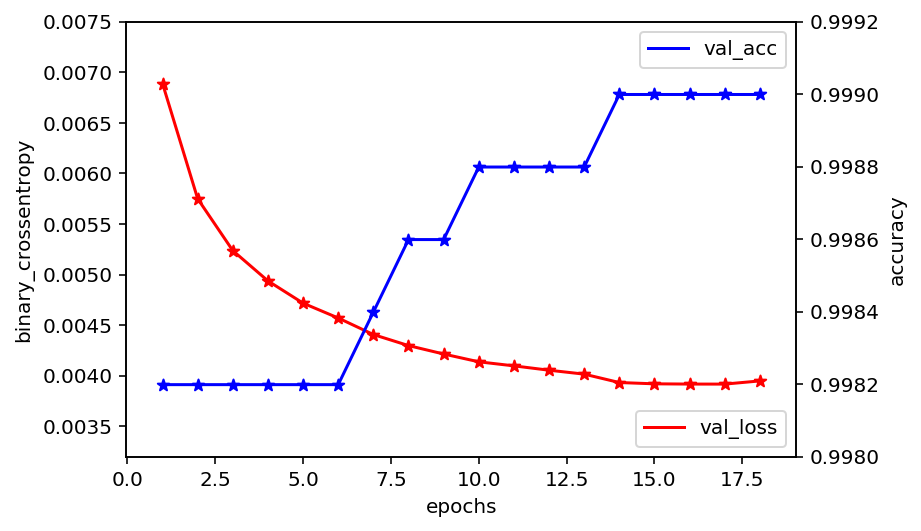

In [83]:
epoch = list(map(lambda x:x+1, result.epoch))
visualize_epochs(epoch, result.history)

In [30]:
test_gen = tl_resnet50.get_test_generator()

In [142]:
import pandas as pd

y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.0045, max=0.9955)

df = pd.read_csv("sample_submission.csv")

for i, fname in enumerate(test_gen.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred_merge.csv', index=None)
df.head(10)

12500/12500 [==============================] - 0s 25us/step


id   label
0   1  0.9955
1   2  0.9955
2   3  0.9955
3   4  0.9955
4   5  0.0045
5   6  0.0045
6   7  0.0045
7   8  0.0045
8   9  0.0045
9  10  0.0045

In [51]:
trainned_nn_clf = model

In [123]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_25 (InputLayer)        (None, 1775)              0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 1775)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 1776      
Total params: 1,776
Trainable params: 1,776
Non-trainable params: 0
_________________________________________________________________


In [227]:
P = shuffle(df['label'], random_state=2018)   #2018
P.iloc[:10]

2886     1.363712e-03
1464     1.016961e-03
12098    5.160078e-01
1007     3.131240e-07
1791     2.690423e-03
11244    3.700483e-09
9841     6.871681e-04
8506     2.270674e-04
394      9.999996e-01
971      1.000000e+00
Name: label, dtype: float64

In [232]:
P = P[P < 0.8]
P = P[P > 0.2]

In [233]:
len(P)

56

In [240]:
P = shuffle(P, random_state=100)

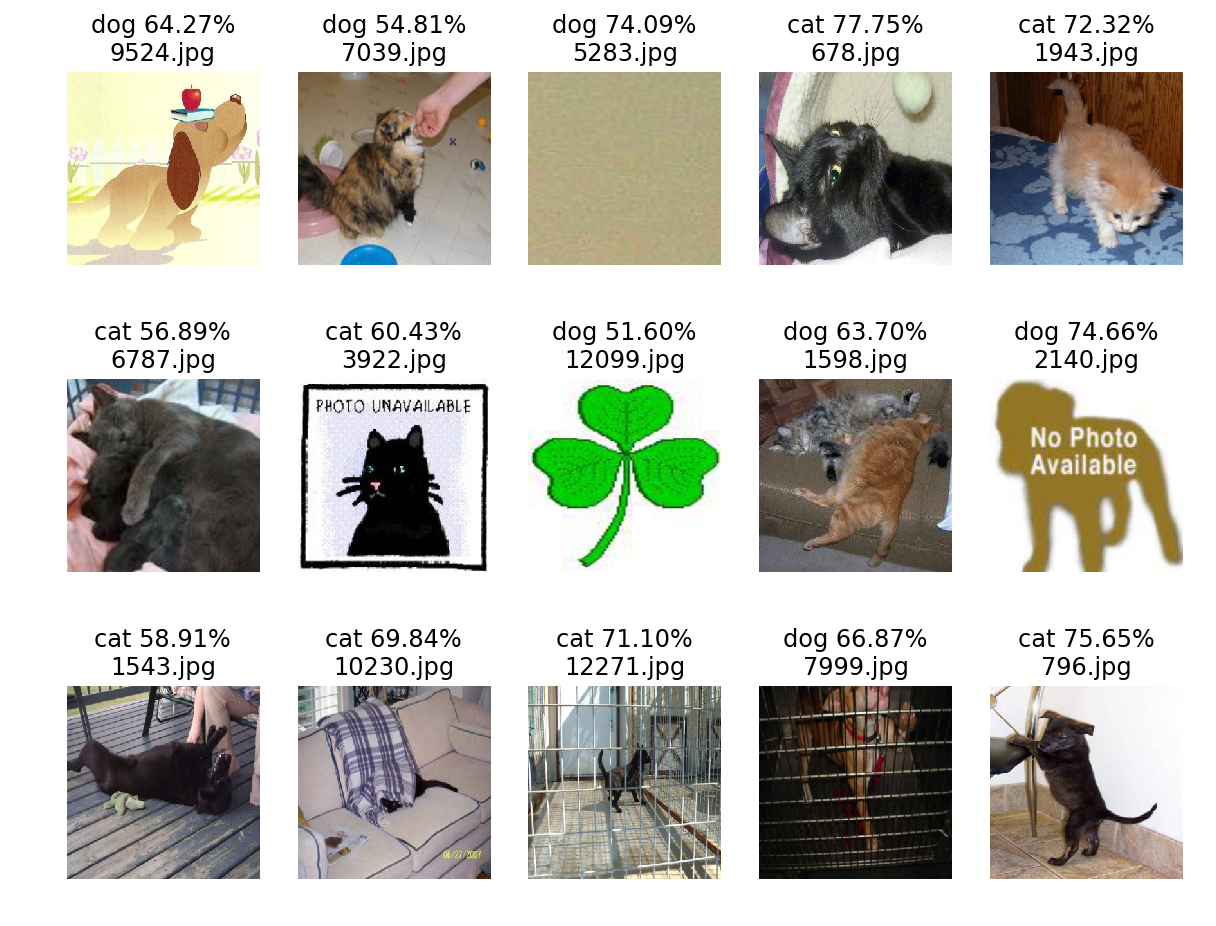

In [368]:
import matplotlib.pyplot as plt
import cv2
%config InlineBackend.figure_format = 'retina'
test_folder = '../capstone/dog_vs_cat/test'

plt.figure(figsize=(10, 8))

i=40
for i, (p,index) in enumerate(zip(P[i:15+i], P.index[i:15+i])):
    img = cv2.resize(plt.imread(os.path.join(test_folder, str(index+1)+'.jpg')), (300, 300))
    plt.subplot(3, 5, i+1)
    label = 'dog' if p>=0.5 else 'cat'
    p = 1-p if p<0.5 else p
    plt.title(label + ' {:.2f}%'.format(p*100) + '\n' + str(index+1)+'.jpg')
    plt.axis('off')
    plt.imshow(img)

plt.show()

### 针对错判样本

In [766]:
train_pred = model.predict(X_train, verbose=1)

25000/25000 [==============================] - 1s 44us/step


In [767]:
pred = (train_pred >= 0.5)*1
pred = pred[:, 0]
pred[:10]

array([0, 1, 0, 1, 1, 0, 0, 1, 0, 0])

In [768]:
error = [i for i,(p,y) in enumerate(zip(pred, y_train)) if p != y]
len(error)

45

In [769]:
for e in error:
    print('Error samples, {}, Truth:{} vs. Pred:{} with probability:{}'.
              format(filenames[e], y_train[e], pred[e], train_pred[e]))

Error samples, cat/cat.4688.jpg, Truth:0 vs. Pred:1 with probability:[ 0.75572121]
Error samples, dog/dog.2614.jpg, Truth:1 vs. Pred:0 with probability:[ 0.36896318]
Error samples, cat/cat.12272.jpg, Truth:0 vs. Pred:1 with probability:[ 0.73625612]
Error samples, dog/dog.10179.jpg, Truth:1 vs. Pred:0 with probability:[ 0.07974119]
Error samples, dog/dog.8444.jpg, Truth:1 vs. Pred:0 with probability:[ 0.4491044]
Error samples, dog/dog.12142.jpg, Truth:1 vs. Pred:0 with probability:[ 0.3146241]
Error samples, cat/cat.11544.jpg, Truth:0 vs. Pred:1 with probability:[ 0.5009684]
Error samples, cat/cat.5355.jpg, Truth:0 vs. Pred:1 with probability:[ 0.56366765]
Error samples, dog/dog.10871.jpg, Truth:1 vs. Pred:0 with probability:[ 0.38638115]
Error samples, cat/cat.10712.jpg, Truth:0 vs. Pred:1 with probability:[ 0.60374534]
Error samples, cat/cat.6402.jpg, Truth:0 vs. Pred:1 with probability:[ 0.54166353]
Error samples, dog/dog.2542.jpg, Truth:1 vs. Pred:0 with probability:[ 0.04086568]
E

In [774]:
outlier_2 = [(filenames[e].split('/')[1], y_train[e], train_pred[e]) for e in error 
                 if (y_train[e]==0 and train_pred[e]>=0.65) or (y_train[e]==1 and train_pred[e]<=0.35)]
outlier_2

[('cat.4688.jpg', 0, array([ 0.75572121], dtype=float32)),
 ('cat.12272.jpg', 0, array([ 0.73625612], dtype=float32)),
 ('dog.10179.jpg', 1, array([ 0.07974119], dtype=float32)),
 ('dog.12142.jpg', 1, array([ 0.3146241], dtype=float32)),
 ('dog.2542.jpg', 1, array([ 0.04086568], dtype=float32)),
 ('cat.11399.jpg', 0, array([ 0.72095841], dtype=float32)),
 ('cat.6699.jpg', 0, array([ 0.92082316], dtype=float32)),
 ('cat.7920.jpg', 0, array([ 0.98275489], dtype=float32)),
 ('cat.5241.jpg', 0, array([ 0.94647032], dtype=float32)),
 ('cat.10266.jpg', 0, array([ 0.68943524], dtype=float32)),
 ('dog.5767.jpg', 1, array([ 0.20756567], dtype=float32)),
 ('cat.3658.jpg', 0, array([ 0.74997258], dtype=float32)),
 ('dog.4334.jpg', 1, array([ 0.14133543], dtype=float32)),
 ('dog.5529.jpg', 1, array([ 0.2223174], dtype=float32)),
 ('dog.6921.jpg', 1, array([ 0.20129704], dtype=float32)),
 ('cat.8456.jpg', 0, array([ 0.67883378], dtype=float32)),
 ('dog.9150.jpg', 1, array([ 0.30577999], dtype=float

In [775]:
for f,_,_ in [*outlier_2]:
    print('\''+f+'\',')

'cat.4688.jpg',
'cat.12272.jpg',
'dog.10179.jpg',
'dog.12142.jpg',
'dog.2542.jpg',
'cat.11399.jpg',
'cat.6699.jpg',
'cat.7920.jpg',
'cat.5241.jpg',
'cat.10266.jpg',
'dog.5767.jpg',
'cat.3658.jpg',
'dog.4334.jpg',
'dog.5529.jpg',
'dog.6921.jpg',
'cat.8456.jpg',
'dog.9150.jpg',
'dog.8507.jpg',
'cat.4085.jpg',
'cat.9250.jpg',
'dog.11731.jpg',
'dog.6405.jpg',
'cat.6906.jpg',
'cat.724.jpg',


In [776]:
len(outlier_2)

24

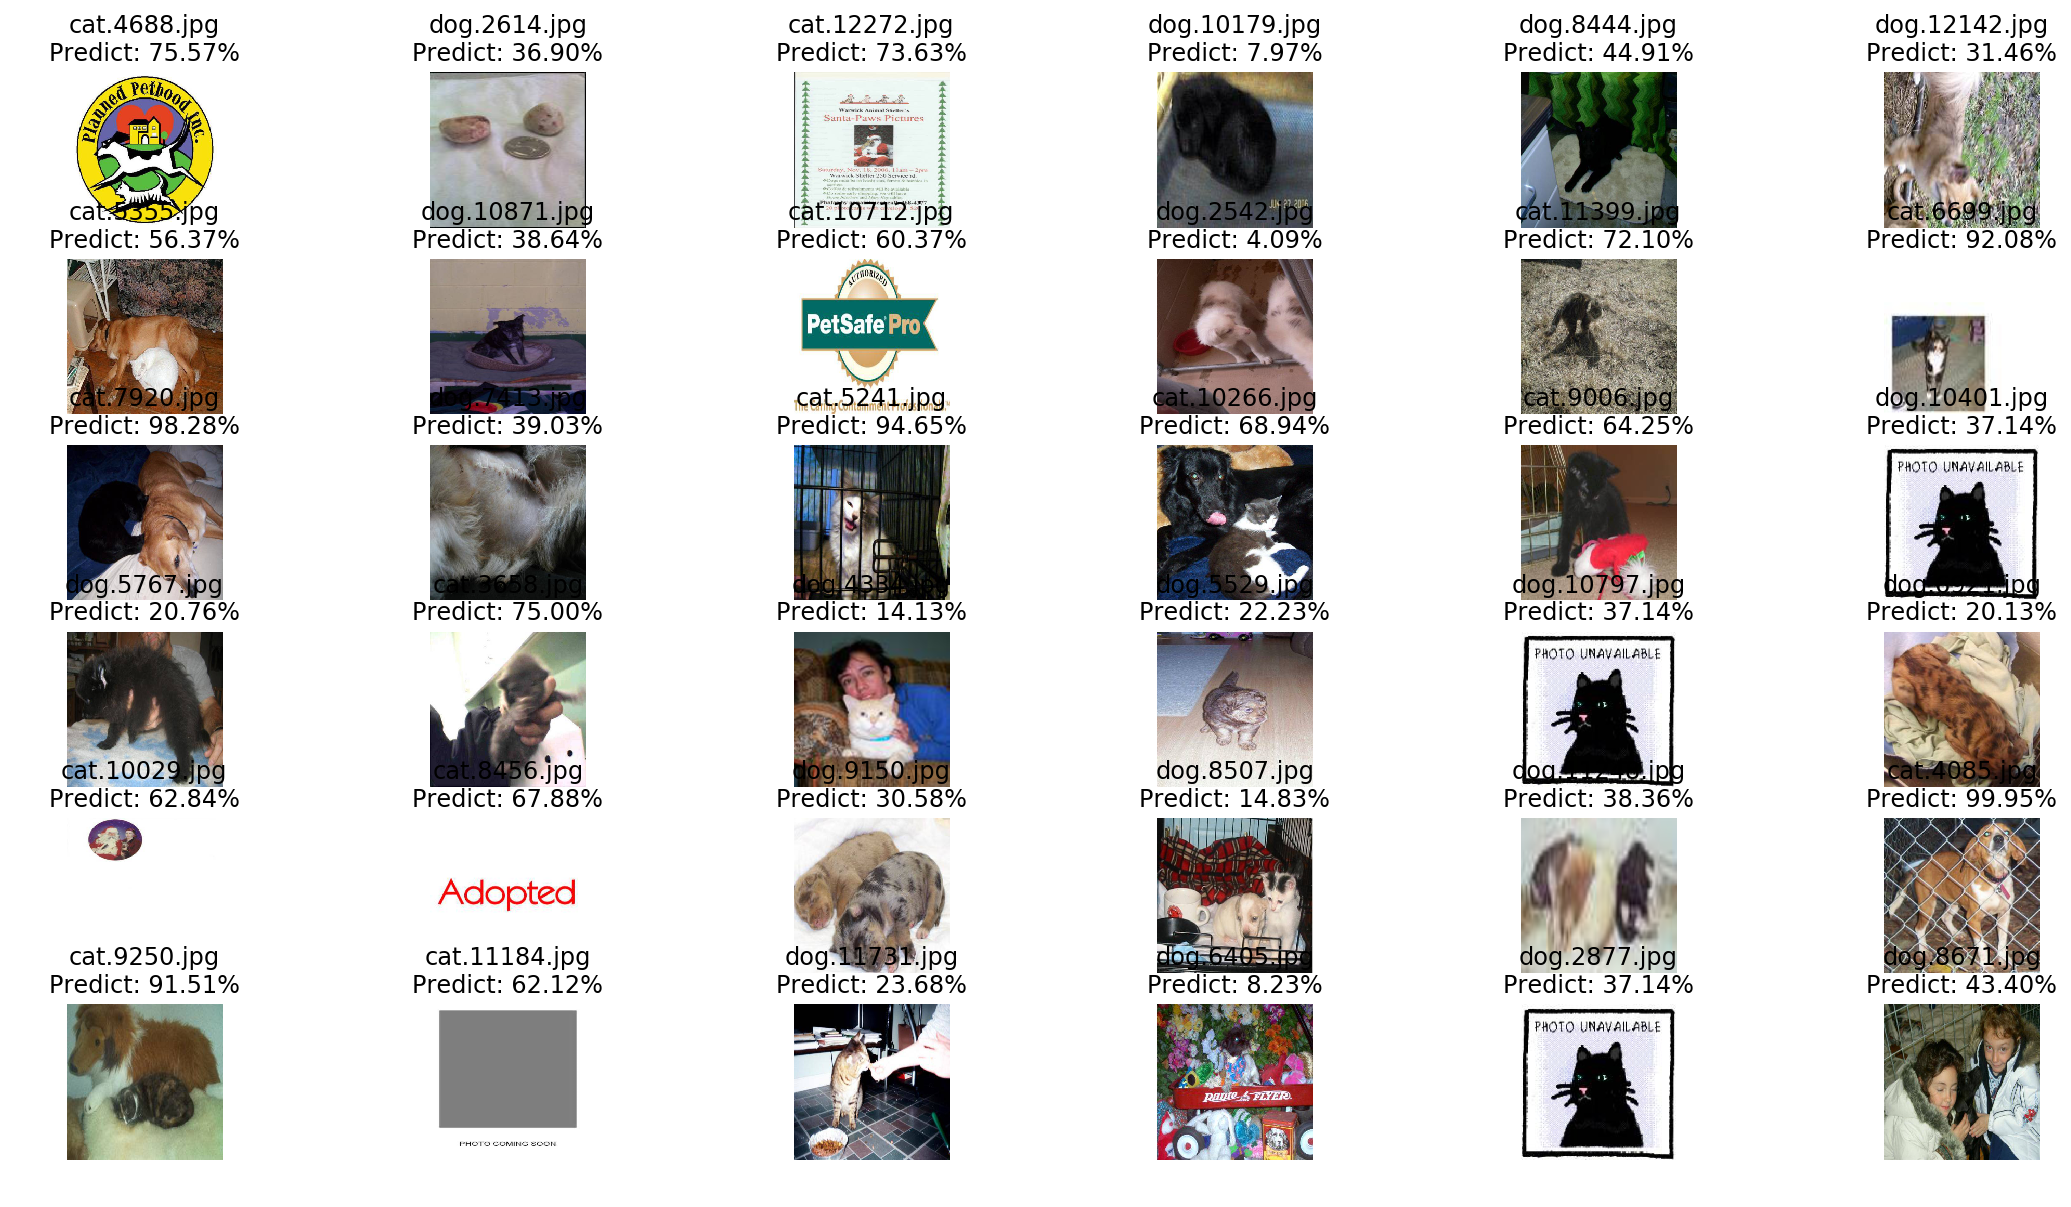

In [773]:
plt.figure(figsize=(19, 10))
train_folder = '../capstone/dog_vs_cat/train'

for i, (f,_,p) in enumerate([*outlier_2][:36]):
    img = cv2.resize(plt.imread(os.path.join(train_folder, f)), (300, 300))
    plt.subplot(6, 6, i+1)
    #p = p if p>=0.5 else (1-p)
    plt.title(f + '\n' + 'Predict: {:.2f}%'.format(p[0]*100))
    plt.axis('off')
    plt.imshow(img)

plt.show()

In [ ]:
'cat.4688.jpg',
 'cat.12272.jpg',
 'cat.7920.jpg',
 'cat.10266.jpg',
 'dog.4334.jpg',
 'dog.6921.jpg',
 'cat.8456.jpg',
 'dog.8507.jpg',
 'cat.4085.jpg',
 'cat.9250.jpg',
 'dog.11731.jpg',
 'cat.724.jpg'